Project SHCT

Authors: Curumi Klejsi, Querzè Lorenzo  
Spring semester 2025

In [2]:
#import os
#os.chdir("/content/SHCT")
#import sys
#sys.path.append("/content/SHCT")
from pylab import *
import numpy as np
import Fluid_CP as FCP #calculation of  thermodynamic states
from scipy.optimize import minimize, NonlinearConstraint, Bounds, minimize_scalar
from scipy.integrate import odeint
from scipy.optimize import bisect
import matplotlib.pyplot as plt
import pandas as pd
from CompressorModel import recip_comp_SP   
import plotDiag_Th_Ts as Diag #plot Th diagram with heat sink and heat source 
import math as _m

In [3]:
# PARAMETERS: 

working_time = 43200 # s, 12 hours in seconds

# Pasta

T_pasta_in = 7 # °C, initial pasta temperature 
T_pasta_fin = 85 # °C, final pasta temperature
m_pasta = 2 # kg, total kg of pasta
m_pasta_basket = 0.5 # kg of pasta per basket
t_break = 300 # s, break time in between batches
t_cook = 420 # s, cooking time for the pasta
R_h2o_pasta = 15 # K/kW, thermal resistance between pasta and water
cp_pasta = 3.5 # kJ/kg K, heat capacity of pasta

# H2O (sink)

T_sink_in = 20 # °C, initial water temperature in the morning
T_min_h2o = 85 # °C, minimum water temperature during operation
T_max_h2o = 93 # °C, maximum water temperature during operation
R_h2o_env = 30 # K/kW, thermal resistance between environment and water
cp_h2o = 4.18 # kJ/kg K, heat capacity of water
rho = 1/FCP.state(['T','p'],[T_max_h2o,1],fluid='water',Eh='CBar')['v'] # kg/m^3, density of water

# Air (source)

T_source = 20 # °C, heat source temperature, constant in cross-flow configuration

# Geometry of the pasta cooker:

h = 0.20 # m
w = 0.27 # m
l = 0.47 # m
V = h*w*l

# Heat duty to heat up the water from 85 to 93°C:

# Assumptions during modeling: 
# - 0D problem: no temperature gradient inside h2o and pasta
# - constant properties for water and pasta ---> therefore, thermal resistances and cps of pasta and water are constant

# Heat pump design:
# subcritical heat pump process
# techical constraints: superheating, subcooling, optimal COP, pinch points are respected...

TASK 1: simulate pasta cooking step

In [4]:
# REQUIRED THERMAL ENERGY INPUT TO COOK THE PASTA

#Q = m_pasta*cp_pasta*(T_pasta_fin - T_pasta_in)
#print('The required thermal energy input to cook pasta is: ', Q, ' kJ')
#Q_dot = Q/t_cook
#print('The required thermal power input to cook pasta is: ', Q_dot, ' kW')

In [36]:
# Derived capacities
C_w = rho * V * cp_h2o          # kJ K⁻¹
C_p = m_pasta * cp_pasta        # kJ K⁻¹


# Integration set-up
dt       = 1.0                                  # s
steps_c  = int(t_cook  / dt)
steps_br = int(t_break / dt)


def update_pump_state(T_w: float, pump_on: bool) -> bool:
    """
    Hysteresis controller:
    - If currently OFF and T_w ≤ 85 °C  → switch ON
    - If currently ON  and T_w ≥ 93 °C  → switch OFF
    - Otherwise keep previous state
    """
    if pump_on:
        return False if T_w >= T_max_h2o-0.05 else True
    else:
        return True  if T_w <= T_min_h2o+0.05 else False
    

def run_cycle(Q_hp):
    T_w = T_max_h2o           # start bath hot
    T_p = T_pasta_in
    pump_on = False           # initial compressor state

    # 7-min cook ---------------------------------------------------
    for _ in range(steps_c):
        pump_on = update_pump_state(T_w, pump_on)
        Q = Q_hp if pump_on else 0.0
        q_wp = (T_w - T_p) / R_h2o_pasta
        q_wa = (T_w - T_source) / R_h2o_env
        T_w += dt * (Q - q_wp - q_wa) / C_w
        T_p += dt *  q_wp / C_p

    # 5-min break (reheat) ----------------------------------------
    for _ in range(steps_br):
        pump_on = update_pump_state(T_w, pump_on)
        Q = Q_hp if pump_on else 0.0
        q_wa = (T_w - T_source) / R_h2o_env
        T_w += dt * (Q - q_wa) / C_w

    return T_p, T_w



def residual(Q_hp):
    Tp_end, Tw_end = run_cycle(Q_hp)

    if not np.isfinite(Tp_end) or not np.isfinite(Tw_end):
        return 1e6  # large penalty

    err_pasta = abs(Tp_end - T_pasta_fin)
    err_water = abs(T_max_h2o - Tw_end)   # penalty only if too cold

    # Option A: treat both equally
    return err_pasta  # weight water recovery more strongly


result = minimize_scalar(residual, bounds=(0.5, 6), method="bounded",
                         options={"xatol": 1e-3})

Q_star = result.x
print(f"Optimal heat pump power Q* = {Q_star:.2f} kW")
print(f"Residual temperature error = {result.fun:.3f} °C")


Optimal heat pump power Q* = 3.42 kW
Residual temperature error = 0.000 °C


Simulation of Full day

Simulating 20 full cycles (240.0 min total)


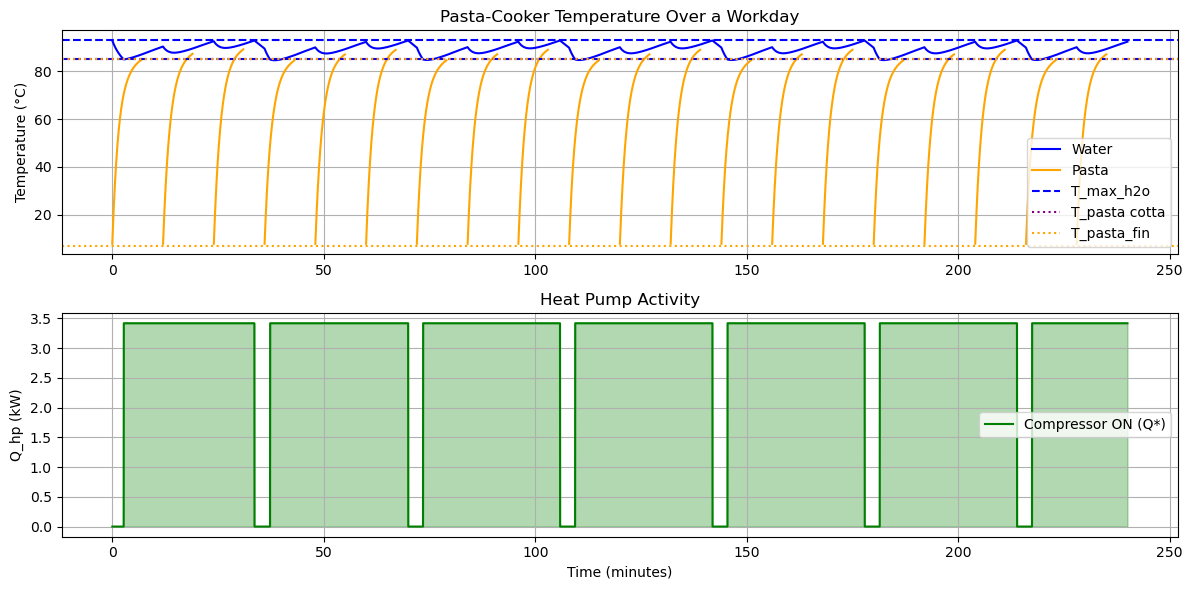

In [37]:
# ────────────────────────────────────────────────────────────────
# Simulate full working day (12 hours) with repeated cook cycles
# ────────────────────────────────────────────────────────────────
working_time = 43200                     # 12 hours in seconds
t_cycle      = t_cook + t_break
n_cycles     = int(working_time / t_cycle)
n_cycles = 20

print(f"Simulating {n_cycles} full cycles ({n_cycles*(t_cycle)/60:.1f} min total)")

T_w = T_max_h2o            # reset bath temp to full-hot at start of day
pump_on = False            # compressor starts OFF

T_w_hist, T_p_hist, pump_hist = [], [], []

for _ in range(n_cycles):
    T_p = T_pasta_in       # fresh pasta at start of every cook cycle

    # 7-min cook phase
    for _ in range(steps_c):
        pump_on = update_pump_state(T_w, pump_on)
        Q = Q_star if pump_on else 0.0
        q_wp = (T_w - T_p) / R_h2o_pasta
        q_wa = (T_w - T_source) / R_h2o_env
        T_w += dt * (Q - q_wp - q_wa) / C_w
        T_p += dt *  q_wp / C_p
        T_w_hist.append(T_w)
        T_p_hist.append(T_p)
        pump_hist.append(pump_on)

    # 5-min break phase (no pasta)
    for _ in range(steps_br):
        pump_on = update_pump_state(T_w, pump_on)
        Q = Q_star if pump_on else 0.0
        q_wa = (T_w - T_source) / R_h2o_env
        T_w += dt * (Q - q_wa) / C_w
        T_w_hist.append(T_w)
        T_p_hist.append(np.nan)       # pasta is out
        pump_hist.append(pump_on)


# Time axis (in minutes)
t_all = np.arange(len(T_w_hist)) * dt / 60

plt.figure(figsize=(12, 6))

# Temperature plot
plt.subplot(2, 1, 1)
plt.plot(t_all, T_w_hist, label="Water", color='blue')
plt.plot(t_all, T_p_hist, label="Pasta", color='orange')
plt.axhline(T_max_h2o,  ls='--', color='blue',   label="T_max_h2o")
plt.axhline(T_min_h2o,  ls='--', color='blue')
plt.axhline(85, ls=':', color='purple', label="T_pasta cotta")
plt.axhline(T_pasta_fin, ls=':', color='orange', label="T_pasta_fin")
plt.axhline(T_pasta_in,  ls=':', color='orange')
plt.ylabel("Temperature (°C)")
plt.title("Pasta-Cooker Temperature Over a Workday")
plt.legend()
plt.grid(True)

# Compressor activity plot
plt.subplot(2, 1, 2)
plt.plot(t_all, np.array(pump_hist)*Q_star, color="green", label="Compressor ON (Q*)")
plt.fill_between(t_all, 0, np.array(pump_hist)*Q_star, color="green", alpha=0.3)
plt.ylabel("Q_hp (kW)")
plt.xlabel("Time (minutes)")
plt.title("Heat Pump Activity")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# print(T_w_hist)

In [38]:
# def model(y,t,Q):
#     T_h2o, T_pasta = y
#     Q_dot_env = (T_h2o - T_source) / R_h2o_env
#     Q_dot_pasta = (T_h2o - T_pasta) / R_h2o_pasta
#     if Q > 0:        
#         dT_h2o_dt = (- Q_dot_pasta + Q) / (V * rho * cp_h2o) # - Q_dot_env - Q_dot_pasta
#     else:
#         dT_h2o_dt = (- Q_dot_env - Q_dot_pasta) / (V * rho * cp_h2o)
#     dT_pasta_dt = (Q_dot_pasta) / (m_pasta * cp_pasta)

#     return [dT_h2o_dt, dT_pasta_dt]

In [39]:
# # Simulation setup

# dt = 1
# t_sim = np.arange(0, t_cook+dt, dt)
# state = [T_max_h2o, T_pasta_in]  # [T_h2o, T_pasta]
# T_h2o = [state[0]]
# T_pasta = [state[1]]
# Q_track = [0]
# heat_pump = "off"
# Q=0

# # Time loop

# for i in range(1, len(t_sim)):
    
#     Tprev = state[0]

#     # --- Controller Logic ---
#     if Tprev <= T_min_h2o:
#         if heat_pump == "off":
#             heat_pump = "on"
#             Q = Q_h2o        
    
#     elif Tprev >= T_max_h2o:
#         if heat_pump == "on":
#             heat_pump = "off"
#             Q = 0       
    
#     elif T_min_h2o < Tprev < T_max_h2o:
#         if heat_pump == "on":
#             Q = Q_h2o
#         else:
#             Q = 0
    
#     # Integrate one step
#     state_next = odeint(model, state, [0, dt], args=(Q,))
#     state = state_next[-1]  # update current state

#     # Store
#     T_h2o.append(state[0])
#     T_pasta.append(state[1])
#     Q_track.append(Q)
# plt.plot(t_sim, T_h2o, label='Water', color='blue')
# plt.plot(t_sim, T_pasta, label='Pasta', color='orange')
# plt.axhline(T_max_h2o)
# plt.axhline(T_min_h2o)
# plt.xlabel('Time [s]')
# plt.ylabel('Temperature [°C]')
# plt.legend()
# plt.grid(True)
# plt.title("Pasta cooking with heat pump on/off control")
# plt.show()
# #print(T_h2o)
# #print(T_pasta)
# plt.plot(t_sim, Q_track)

In [40]:
# def h2o_energy_balance(x):
#     T_in, T_fin = x
#     rho = 1/FCP.state(['T','p'],[T_in,1],fluid='water',Eh='CBar')['v']
#     T_water = np.linspace(T_in, T_fin, t_cook)
#     T_pasta = np.linspace(T_pasta_in, T_pasta_fin, t_cook)
#     Q = 0
#     for t in range(0,t_cook):
#         Q = Q + (T_water[t]-T_source)/R_h2o_env + (T_water[t]-T_pasta[t])/R_h2o_pasta
#     return np.abs(rho*cp_h2o*V*(T_water[0] - T_water[-1]) - Q)

# def h2o_constraint(x):
#     T_in, T_fin = x
#     return T_in - T_fin

In [41]:
# t = linspace(0,t_cook, t_cook+1)
# print(t)

In [42]:
# NC1 = NonlinearConstraint(h2o_constraint, 0, np.inf)
# bounds = [(85,93),(85,93)]
# x0 = [91,87]
# res = minimize(h2o_energy_balance, x0, method='SLSQP', bounds=bounds, constraints=[NC1])
# print(res.x)
# print(res.fun)

In [43]:
# def h2o_final_temperature(T):
#     rho = 1/FCP.state(['T','p'],[T,1],fluid='water',Eh='CBar')['v']
#     dt = 1 # timestep
#     for i in t:
        

Condenser characteristcs

In [44]:
w = 0.27 # m
l = 0.47 # m
d_out = 6.35e-3
t_tube = 0.83e-3
d_in = d_out - 2*t_tube 
spacing = 2e-3
A_corner = 4 *pi*pi * (d_out/2) * ((d_out+spacing)/2)
L_straight = l - 2*spacing - 2*(spacing/2 + d_out)
A_straight = 2 * pi * (d_out/2) * L_straight
edge = (spacing/2) + d_out
A_edge = 2 * pi * (d_out/2) * edge

n = (w-spacing)/(d_out+spacing) 
A_tot = 2*(A_straight+A_edge) + (n-1)*A_corner + (n-2)*A_straight

L_eff = A_tot / (pi * d_out)

print('Number od tubes: ', n)
print('Total area of tubes: ', A_tot)
print(f"effective straight length = {L_eff:.2f} m")




Number od tubes:  32.09580838323354
Total area of tubes:  0.30552571520994104
effective straight length = 15.32 m


Calcualte resistances 

In [45]:
# Heat transfer coefficients

# The thermal conductivity of 316L stainless steel (SS) seamless tubing, which is covered by ASTM A269
lambda_steel = 16.3 # W/m K,

# air
h_air=300      # W/m² K,

# refrigerant 
h_refVL = 2000 # W/m² K,
h_refV = 200   # W/m² K, 
h_refL = 1000  # W/m² K,

# water
h_h2o = 1000   # W/m² K,
T_sink_in = 20 # °C, initial water temperature in the morning

#  Assumptions for T_ev and T_co
# T_ev = 5  # °C, evaporator temperature
# T_co = 40 # °C, condenser temperature
# delta_T_sh = 10 # °C, superheating temperature difference
# delta_T_sc = 5 # °C, subcooling temperature difference
# fluid="Butene" # refrigerant used in the heat pump
Eh="CBar"
pinch = 0.5 # °C, pinch point temperature difference


In [46]:
#thermal resistance times tube length for convective heat transfer
def calc_RL_conv(h,d):
    R_L_conv=1./(h*pi*d) #mK/W
    return R_L_conv

#thermal resistance times tube length for conductive heat transfer
def calc_RL_cond(lambda_w,d_w,d_out,d_i):
    R_L_cond= d_w/(lambda_w*((d_out-d_i)/(log(d_out/d_i)))*pi) #mK/W
    return R_L_cond

In [47]:
#convective heat transfer inner tube wall
R_L_h_refV=calc_RL_conv(h_refV,d_in)
#convective heat transfer inner tube wall
R_L_h_refVL=calc_RL_conv(h_refVL,d_in)
#conductive heat transfer through wall
R_L_lambda=calc_RL_cond(lambda_steel,t_tube, d_out,d_in)
#convective heat transfer outer tube wall
R_L_h_h2o=calc_RL_conv(h_h2o,d_out)
#liquid refr convective heat transfer outer tube wall
R_L_h_refL=calc_RL_conv(h_refL,d_out)


R_L_co_vl = R_L_h_refVL + R_L_lambda + R_L_h_h2o

R_L_co_v = R_L_h_refV + R_L_lambda + R_L_h_h2o

R_L_co_l = R_L_h_refL + R_L_lambda + R_L_h_h2o


In [ ]:
def cycle_states (param, D, fluid):
#state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    T_ev, T_co, delta_T_sh, delta_T_sc = param
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh+0.1,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat

    #state 3: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    if delta_T_sc>0.:
        state3=FCP.state(["T","p"],[T_co-delta_T_sc-0.1,state3_sat["p"]],fluid,Eh)
    else:
        state3=state3_sat

    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    

    param1 = np.concatenate((param, [D]))
    # print('param1:',param1)
    eta_is, m_dot = recip_comp_SP(param1, fluid, transcrit=False)

        

    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    # print("h2 =", h2)
    
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)

    Q_dot_cond = m_dot * (state2["h"] - state3["h"])
    W_dot_comp = m_dot * (state2["h"] - state1["h"])
    
    # print("Q_dot_cond =", Q_dot_cond)
    
    COP     = Q_dot_cond / W_dot_comp

    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[state1["p"],state3["h"]],fluid,Eh)
    
    return {"1": state1, "2": state2, "3": state3, "4": state4,
            "T_ev": T_ev, "T_co": T_co,
            "m_dot": m_dot, "η_is": eta_is,
            "Q_cond": Q_dot_cond, "W_comp": W_dot_comp,
            "COP": COP,
            "fluid": fluid}


In [49]:
def pinch_con(states):
    T3, T2 = states["3"]["T"], states["2"]["T"]
    # sink water is assumed single-pass, no temp rise
    delta_T_out  = T3 - T_min_h2o
    delta_T_in   = T2 - T_min_h2o
    delta_T_dew  = states["T_co"] - T_min_h2o
    return np.array([delta_T_in, delta_T_out, delta_T_dew])

In [50]:
def pinch_evap(states):
    T1, T4 = states["1"]["T"], states["4"]["T"]
    delta_T_out = T_source - T1
    delta_T_in  = T_source - T4                 # source side once-through
    return np.array([delta_T_in, delta_T_out])

In [51]:
def objective(param):
    st = cycle_states(param, D, fluid)
    return (st["Q_cond"] - Q_star)**2          # least-squares target

In [88]:
def pinch_wrapper(param):
    st = cycle_states(param, D, fluid)
    delta_T_co = pinch_con(st)
    delta_T_ev = pinch_evap(st)
    return np.hstack((delta_T_co, delta_T_ev))

In [89]:
# bounds: keep the search in physically sensible region
min_sh = 2  # °C, minimum superheating
max_sh = 12 # °C, maximum superheating
min_sc = 0  # °C, minimum subcooling
max_sc = 10 # °C, maximum subcooling



bnds = Bounds(
    [-10, T_min_h2o, min_sh, min_sc],  # lower bounds
    [T_source, 100,     max_sh, max_sc]  # upper bounds
)

nlc  = NonlinearConstraint(pinch_wrapper,
                           lb=np.full(5, pinch),
                           ub=np.full(5, np.inf))

# initial guess
T_ev = 5   # °C, evaporator temperature
T_co = 85  # °C, condenser temperature
delta_T_sh = 5  # °C, superheating temperature difference
delta_T_sc = 5   # °C, subcooling temperature difference

Ds = [35,40,45,50]  # mm, diameter of the compressor (35 mm)
# fluids = ["Isobutane", "Butane", "Isobutene", "DME"]  # refrigerant used in the heat pump
fluids = ["Isobutane"]  # refrigerant used in the heat pump
COP_matrix = np.zeros((len(fluids), len(Ds)))
results = []

for i_d, D in enumerate(Ds):
    for i_f, fluid in enumerate(fluids):
        x0 = np.array([T_ev, T_co, delta_T_sh, delta_T_sc])

        print(f"\n\nRunning cycle with D={D} mm, fluid={fluid}")
        try:
            st = cycle_states(x0,D, fluid)
            res  = minimize(objective, x0,
                            method="SLSQP",
                            bounds=bnds,
                            constraints=[nlc],
                            options={"ftol": 1e-4})
            
            st = cycle_states(res.x, D, fluid)

            # Store COP in matrix for plotting
            COP_matrix[i_f, i_d] = st["COP"]

            # Store full results for DataFrame
            results.append({
                "Fluid": fluid,
                "D (mm)": D,
                "T_ev (°C)": res.x[0],
                "T_co (°C)": res.x[1],
                "Superheat (°C)": res.x[2],
                "Subcooling (°C)": res.x[3],
                "m_dot (kg/s)": st["m_dot"],
                "W_comp (kW)": st["W_comp"],
                "Q_cond (kW)": st["Q_cond"],
                "COP": st["COP"]
            })

        except Exception as e:
            print(f"Failed for D={D}, fluid={fluid} → {e}")
            COP_matrix[i_f, i_d] = np.nan


df_results = pd.DataFrame(results)
print(df_results)




Running cycle with D=35 mm, fluid=Isobutane


Running cycle with D=40 mm, fluid=Isobutane


Running cycle with D=45 mm, fluid=Isobutane


Running cycle with D=50 mm, fluid=Isobutane
       Fluid  D (mm)  T_ev (°C)  T_co (°C)  Superheat (°C)  Subcooling (°C)  \
0  Isobutane      35   5.804577  87.761446        5.082270         2.161446   
1  Isobutane      40   2.759095  90.377215        4.775055         0.000000   
2  Isobutane      45  -2.448406  94.286720        3.867556         0.000000   
3  Isobutane      50  -6.735474  98.780323        2.221339         9.999571   

   m_dot (kg/s)  W_comp (kW)  Q_cond (kW)       COP  
0      0.012068     1.606192     3.415313  2.126342  
1      0.013277     1.942622     3.673527  1.891015  
2      0.012058     2.095878     3.418243  1.630936  
3      0.010383     2.182720     3.418140  1.566000  


In [91]:


optimized_values = [
    df_results.loc[0, 'T_ev (°C)'],
    df_results.loc[0, 'T_co (°C)'],
    df_results.loc[0, 'Superheat (°C)'],
    df_results.loc[0, 'Subcooling (°C)'],
]
print("Optimized values (T_ev, T_co, Superheat, Subcooling):", optimized_values)
st = cycle_states(optimized_values, D, fluid)
Q_cond = st["Q_cond"]
print("Q_cond:", Q_cond)
print(df_results.loc[0, 'Q_cond (kW)'],)
# print("COP: ", st["COP"])
# print("T_ev, T_co, delta_T_sh, delta_T_sc =", st["T_ev"], st["T_co"], df_results.loc[0, 'Superheat (°C)'], df_results.loc[0, 'Subcooling (°C)'])
# Diag.Th(st["1"],st["2"],st["3"],st["4"],[T_min_h2o,T_min_h2o],[T_source,T_source],fluid,Eh)



Optimized values (T_ev, T_co, Superheat, Subcooling): [5.804576649778543, 87.7614461024757, 5.0822695708213494, 2.161446102475705]
Q_cond: 6.970027250560185
3.415313352774491


In [86]:

T_ev_opt = df_results.loc[0, 'T_ev (°C)']
T_co_opt = df_results.loc[0, 'T_co (°C)']

delta_T_vl = T_co_opt - T_min_h2o

T2 = st["2"]["T"]
delta_T_v = (T2 - T_co_opt) / (log((T2-T_min_h2o)/(T_co_opt-T_min_h2o)))

T3_x0=FCP.state(["T","x"],[T_co_opt,1],fluid,Eh)["T"]
delta_T_l = ()


h3_x1=FCP.state(["T","x"],[T_co_opt,1],fluid,Eh)["h"]
h3_x0=FCP.state(["T","x"],[T_co_opt,0],fluid,Eh)["h"]

Q_dot_l = st["m_dot"] * (h3_x0 - st["3"]["h"]) # kW, heat transfer in the condenser liquid line
Q_dot_vl = st["m_dot"] * (h3_x1 - h3_x0) # kW, heat transfer in the condenser vapor/liquid line
Q_dot_v = st["m_dot"] * (st["2"]["h"] - h3_x1) # kW, heat transfer in the condenser vapor line
Q_dot_tot = Q_dot_vl + Q_dot_v + Q_dot_l # kW, total heat transfer in the condenser
Q_dot =     st["Q_cond"] # kW, heat transfer in the condenser
print("Heat transfer in the condenser liquid line (Q_dot_l):", Q_dot)

print(Q_dot_l)
print(Q_dot_vl)
print(Q_dot_v)
print(Q_dot_tot)

# print(delta_T_vl)

# print(R_L_co_v)
# print(R_L_co_vl)
# print(Q_dot_v)

# L_vl = (R_L_co_vl * Q_dot_vl *1000) / delta_T_vl
# L_v = (R_L_co_v * Q_dot_v *1000) / delta_T_v
# L_l = (R_L_co_l * Q_dot_l *1000) / delta_T_l
# print(L_v)
# print(L_vl)


Heat transfer in the condenser liquid line (Q_dot_l): 6.970027250560185
0.16956550555762506
5.858253633999812
0.9422081110027475
6.970027250560184


/var/folders/jv/wwh_hms11m3blxjgltrjv4580000gn/T/ipykernel_30035/2440764513.py:27: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



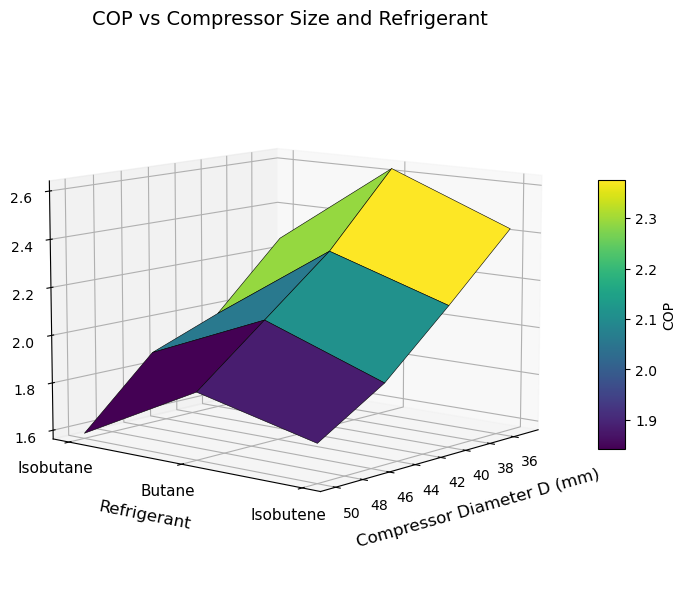

In [203]:
# Create mesh grid
X, Y = np.meshgrid(Ds, range(len(fluids)))
Z = COP_matrix

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, edgecolor='k', linewidth=0.4, antialiased=True)

# Axis labels
ax.set_xlabel("Compressor Diameter D (mm)", labelpad=10, fontsize=12)
ax.set_ylabel("Refrigerant", labelpad=10, fontsize=12)
ax.set_zlabel("COP", labelpad=10, fontsize=12)

# Replace fluid index with names
ax.set_yticks(range(len(fluids)))
ax.set_yticklabels(fluids, fontsize=11)

# Title and color bar
ax.set_title("COP vs Compressor Size and Refrigerant", fontsize=14, pad=15)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="COP")

# Optional: adjust view angle for better clarity
ax.view_init(elev=10, azim=40)

plt.tight_layout()
plt.show()

In [180]:
import plotly.graph_objects as go
# Prepare data
X, Y = np.meshgrid(Ds, range(len(fluids)))  # X: compressor diameters, Y: fluid indices
Z = COP_matrix

# Create surface plot
fig = go.Figure(data=[
    go.Surface(
        z=Z,
        x=X,
        y=Y,
        colorscale='Viridis',
        colorbar=dict(title="COP"),
        showscale=True,
        contours = {"z": {"show": True, "start": np.nanmin(Z), "end": np.nanmax(Z), "size": 0.2, "color":"white"}}
    )
])

# Update axes
fig.update_layout(
    title="COP vs Compressor Diameter and Refrigerant",
    scene=dict(
        xaxis=dict(title='Compressor Diameter D (mm)'),
        yaxis=dict(title='Refrigerant', tickvals=list(range(len(fluids))), ticktext=fluids),
        zaxis=dict(title='COP'),
        camera=dict(eye=dict(x=1.5, y=1.2, z=0.8)),
    ),
    autosize=True,
    height=600,
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()